## Controllable Generation
您将制作一个条件 GAN，以生成数字的手写图像，条件是要生成的数字（类向量）。这将让您选择要生成的数字。

In [58]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

## Generator and Discriminator 

In [59]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        input_dim: the dimension of the input vector, a scalar
        im_chan: the number of channels of the output image, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, input_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):       
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)



class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
      im_chan: the number of channels of the output image, a scalar
            (MNIST is black-and-white, so 1 channel is your default)
      hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of the DCGAN; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

## 分类信息输入
- pytorch 有一个函数import torch.nn.functional as F  ;F.one_hot(labels,n_classes)
- 您需要能够将 one-hot 类向量连接到噪声向量，然后再将其提供给生成器。在将类通道添加到鉴别器时，您也需要这样做。为此，您需要编写一个组合两个向量的函数。请记住，您需要确保向量是相同的类型：浮点数。

In [60]:
# GRADED FUNCTION: combine_vectors
def combine_vectors(x, y):
    '''这里用 torch.cat()，还可以用多种方式混合拼接
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Parameters:
      x: (n_samples, ?) the first vector. 
        In this assignment, this will be the noise vector of shape (n_samples, z_dim), 
        but you shouldn't need to know the second dimension's size.
      y: (n_samples, ?) the second vector.
        Once again, in this assignment this will be the one-hot class vector 
        with the shape (n_samples, n_classes), but you shouldn't assume this in your code.
    '''
    # Note: Make sure this function outputs a float no matter what inputs it receives
    #### START CODE HERE ####
    combined = torch.cat((x.float(),y.float()), 1)
    #### END CODE HERE ####
    return combined

## Training
Now you can start to put it all together!
First, you will define some new parameters:

*   mnist_shape: the number of pixels in each MNIST image, which has dimensions 28 x 28 and one channel (because it's black-and-white) so 1 x 28 x 28
*   n_classes: the number of classes in MNIST (10, since there are the digits from 0 to 9)
 *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   device: the device type

In [61]:
mnist_shape = (1, 28, 28)
n_classes = 10
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])
dataloader = DataLoader( MNIST('.', download=False, transform=transform), batch_size=batch_size,  shuffle=True)

#discriminator 图片变成11个通道，第1个是原图像，后10个为标签，如标签为0第2通道全为1，3-11全为0
generator_input_dim = z_dim + n_classes
discriminator_im_chan = mnist_shape[0] + n_classes

gen = Generator(input_dim=generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(im_chan=discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

100%|██████████| 469/469 [00:29<00:00, 15.92it/s]


Step 9: Generator loss: 1.967765767097473, discriminator loss: 0.33632908841967585


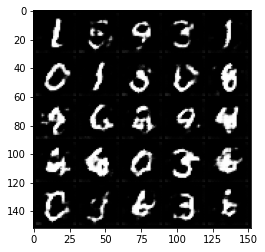

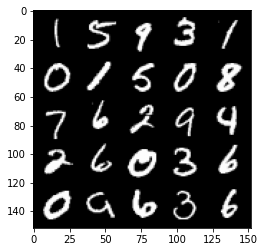

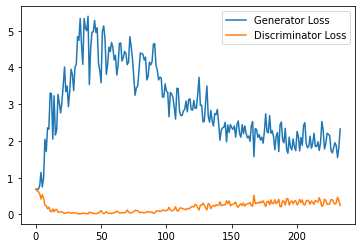

100%|██████████| 469/469 [00:29<00:00, 15.78it/s]


Step 19: Generator loss: 1.3675577851533889, discriminator loss: 0.5217232137322426


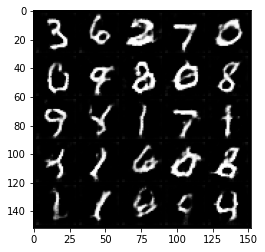

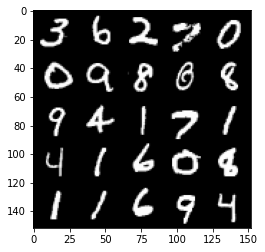

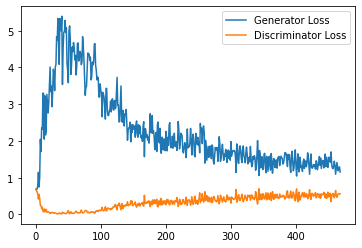

100%|██████████| 469/469 [00:29<00:00, 16.15it/s]


Step 29: Generator loss: 1.0972208845615388, discriminator loss: 0.5834101307988167


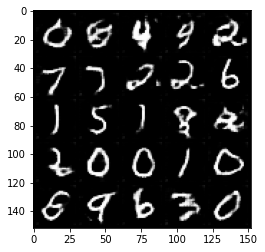

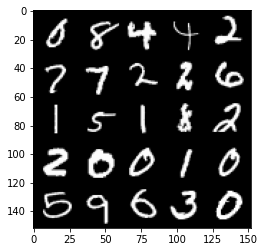

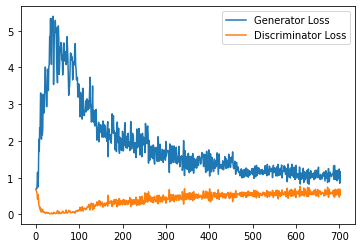

100%|██████████| 469/469 [00:29<00:00, 16.10it/s]

Step 39: Generator loss: 1.0052037600278854, discriminator loss: 0.5978443819880486


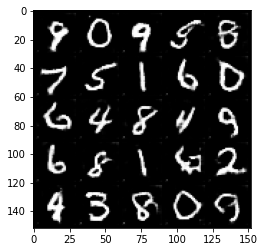

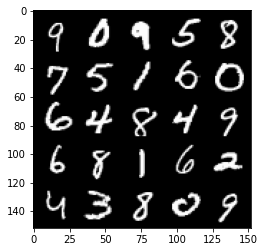

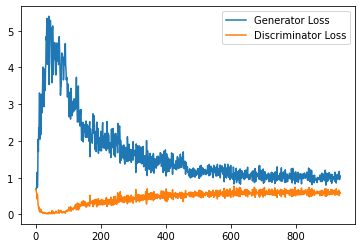

100%|██████████| 469/469 [00:28<00:00, 16.67it/s]


Step 49: Generator loss: 0.9637572740316391, discriminator loss: 0.6043679667711258


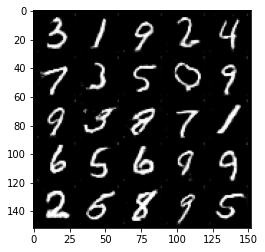

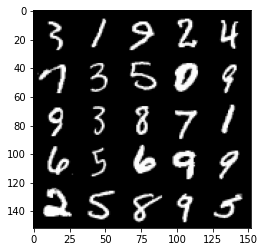

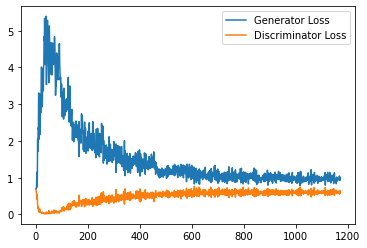

100%|██████████| 469/469 [00:28<00:00, 16.67it/s]


Step 59: Generator loss: 0.9351532332897187, discriminator loss: 0.6204351422190666


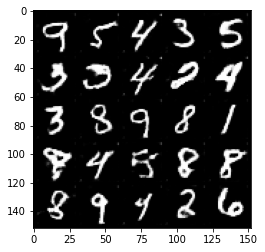

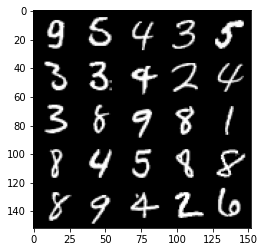

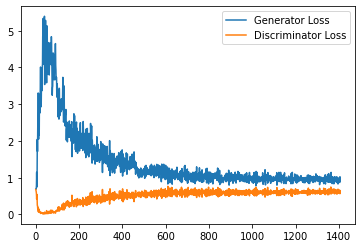

100%|██████████| 469/469 [00:28<00:00, 16.66it/s]


Step 69: Generator loss: 0.9160499467849731, discriminator loss: 0.6270479673147201


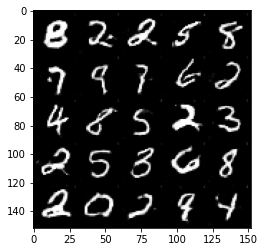

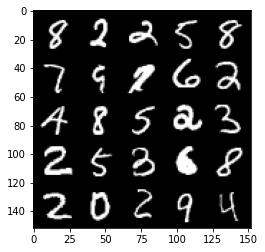

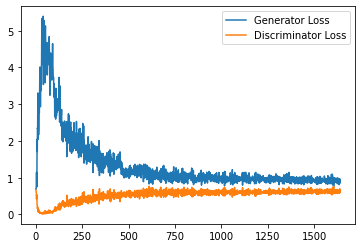

100%|██████████| 469/469 [00:28<00:00, 16.65it/s]


Step 79: Generator loss: 0.9129568672180176, discriminator loss: 0.6378700605630875


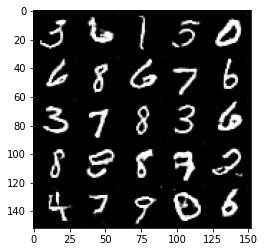

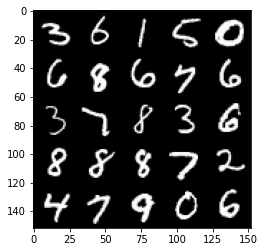

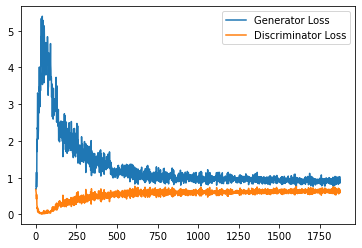

100%|██████████| 469/469 [00:28<00:00, 16.66it/s]


Step 89: Generator loss: 0.9072546269893647, discriminator loss: 0.6311788463592529


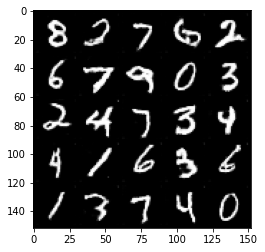

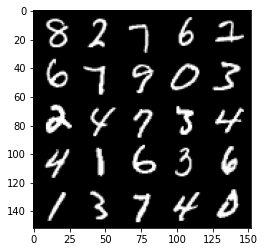

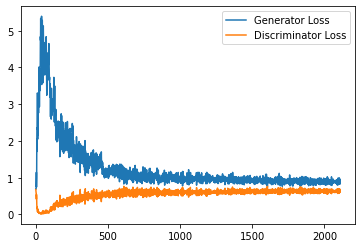

100%|██████████| 469/469 [00:28<00:00, 16.66it/s]


Step 99: Generator loss: 0.9057909517288208, discriminator loss: 0.6262004755139351


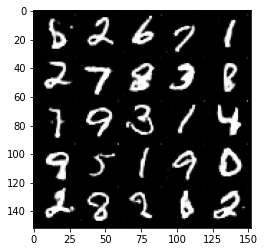

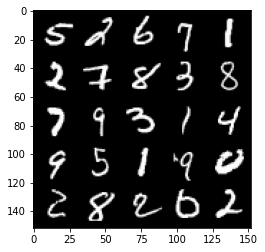

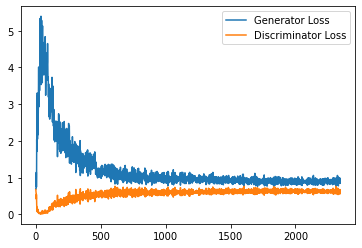

100%|██████████| 469/469 [00:28<00:00, 16.32it/s]


Step 109: Generator loss: 0.920048336148262, discriminator loss: 0.6189080094695091


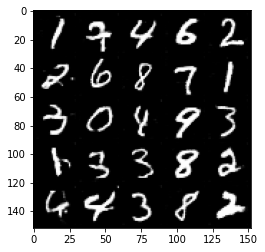

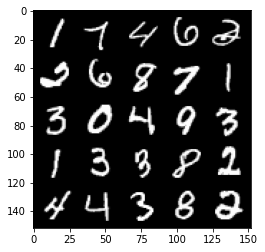

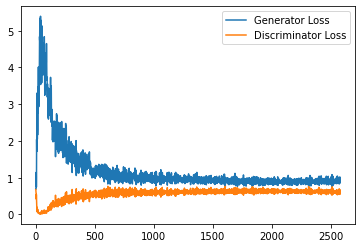

100%|██████████| 469/469 [00:29<00:00, 16.01it/s]


Step 119: Generator loss: 0.92738620865345, discriminator loss: 0.613926743209362


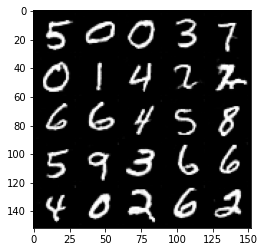

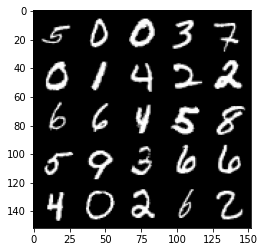

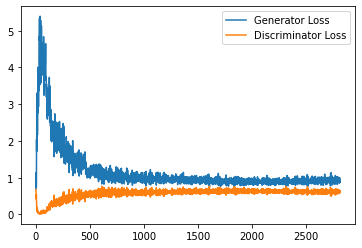

100%|██████████| 469/469 [00:29<00:00, 16.11it/s]

Step 129: Generator loss: 0.9660065672397613, discriminator loss: 0.6084233520030975


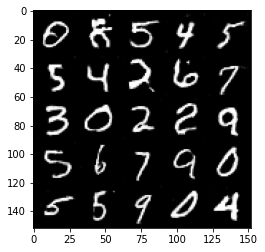

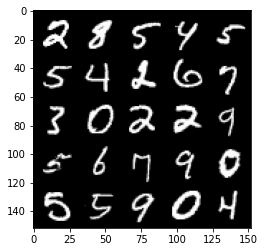

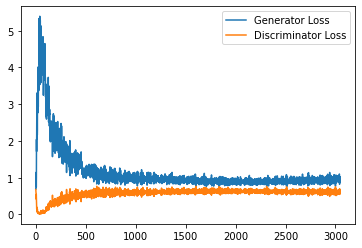

100%|██████████| 469/469 [00:28<00:00, 16.55it/s]


Step 139: Generator loss: 0.9799635964632034, discriminator loss: 0.5958268505334854


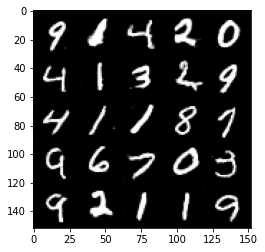

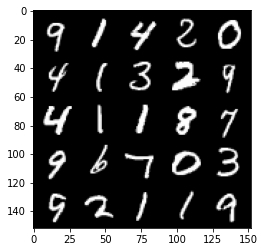

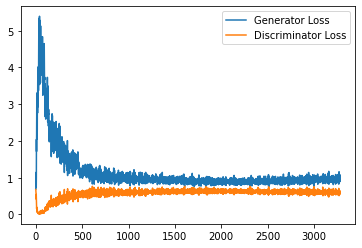

100%|██████████| 469/469 [00:28<00:00, 16.40it/s]


Step 149: Generator loss: 0.9983076485395431, discriminator loss: 0.5887187772393226


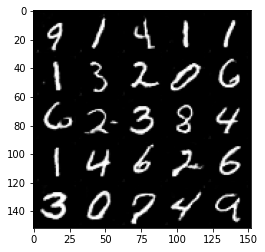

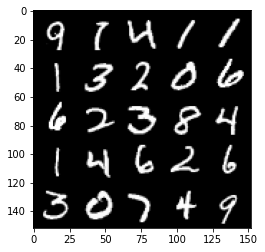

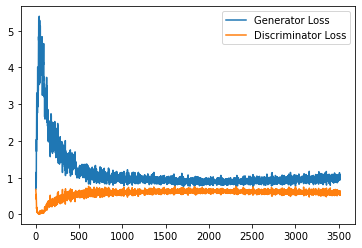

100%|██████████| 469/469 [00:28<00:00, 16.47it/s]


Step 159: Generator loss: 1.002671185851097, discriminator loss: 0.5874397276043892


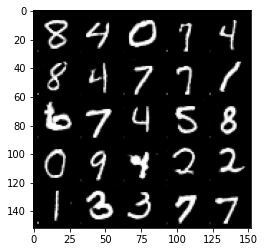

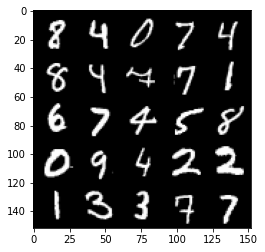

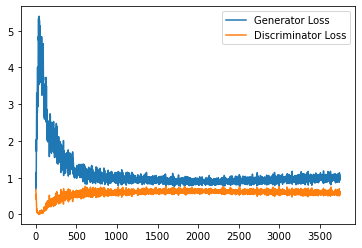

100%|██████████| 469/469 [00:28<00:00, 16.50it/s]


Step 169: Generator loss: 0.9984064589738846, discriminator loss: 0.5923404402732849


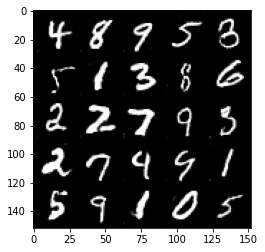

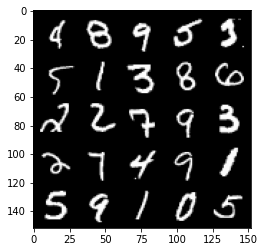

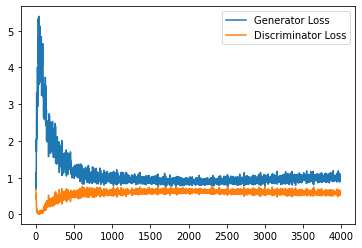

100%|██████████| 469/469 [00:28<00:00, 16.64it/s]


Step 179: Generator loss: 0.9933443044424057, discriminator loss: 0.5833582280874252


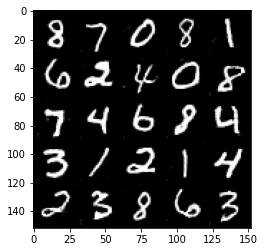

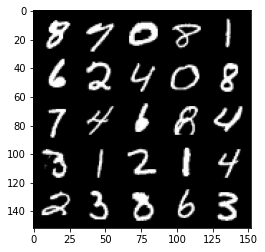

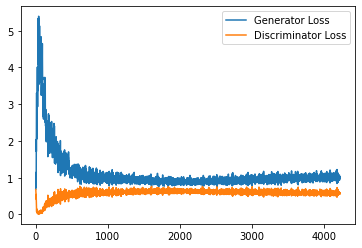

100%|██████████| 469/469 [00:28<00:00, 16.65it/s]


Step 189: Generator loss: 1.0017959694862366, discriminator loss: 0.5959953504800797


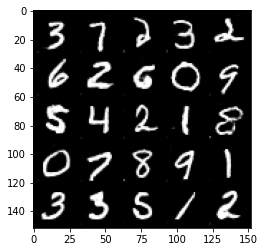

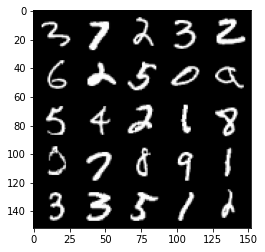

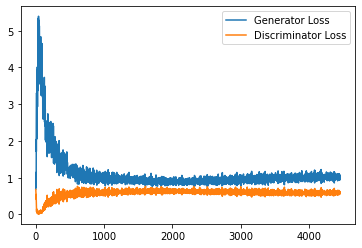

100%|██████████| 469/469 [00:28<00:00, 16.67it/s]


Step 199: Generator loss: 1.0008601588010788, discriminator loss: 0.5901439990401268


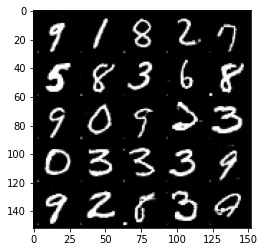

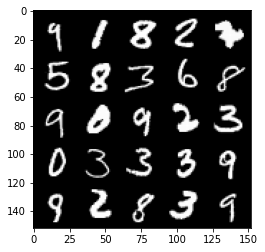

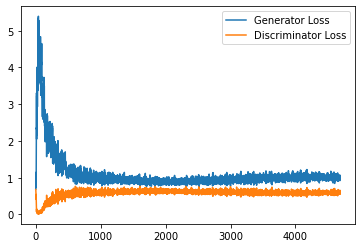

In [62]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CELL
cur_step = 0
generator_losses = []
discriminator_losses = []

#UNIT TEST NOTE: Initializations needed for grading
noise_and_labels = False
fake = False

fake_image_and_labels = False
real_image_and_labels = False
disc_fake_pred = False
disc_real_pred = False

for epoch in range(n_epochs):
    # Dataloader returns the batches and the labels
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)
        # Flatten the batch of real images from the dataset
        real = real.to(device)

        one_hot_labels = F.one_hot(labels.to(device), n_classes)
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, mnist_shape[1], mnist_shape[2])

        ### Update discriminator ###
        # Zero out the discriminator gradients
        disc_opt.zero_grad()
        # Get noise corresponding to the current batch_size 
        fake_noise = torch.randn(cur_batch_size, z_dim, device=device)        
 
        #### START CODE HERE ####
        noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
        fake = gen(noise_and_labels)
        #### END CODE HERE ####       
             
        #### START CODE HERE ####
        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
        real_image_and_labels = combine_vectors(real, image_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels.detach())
        disc_real_pred = disc(real_image_and_labels)
        #### END CODE HERE #### 
        
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step() 

        # Keep track of the average discriminator loss
        discriminator_losses += [disc_loss.item()]

        ### Update generator ###
        # Zero out the generator gradients
        gen_opt.zero_grad()

        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
        # This will error if you didn't concatenate your labels to your image correctly
        disc_fake_pred = disc(fake_image_and_labels)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the generator losses
        generator_losses += [gen_loss.item()]
        #

    if (cur_step+1) % 10 == 0 and cur_step > 0:
        torch.save(gen.state_dict(),f"./checkPoint/CGAN-G-{cur_step}.pth")
        torch.save(gen.state_dict(),f"./checkPoint/CGAN-D-{cur_step}.pth")
        gen_mean = sum(generator_losses[-display_step:]) / display_step
        disc_mean = sum(discriminator_losses[-display_step:]) / display_step
        print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
        show_tensor_images(fake)
        show_tensor_images(real)
        step_bins = 20
        x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
        num_examples = (len(generator_losses) // step_bins) * step_bins
        plt.plot(range(num_examples // step_bins), 
            torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
            label="Generator Loss" )
        plt.plot(range(num_examples // step_bins),
            torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
            label="Discriminator Loss" )
        plt.legend()
        plt.show()
    
    cur_step += 1